<img src='../images/gdd-logo.png' width='300px' align='right' style="padding: 15px">

# <font color='#1EB0E0'>From Notebook to CLI</font>

We will review the notebook code a "Data Scientist in your team has created" to predict outcome types.

We will add it to our package and add a CLI to control how we use the model.

- [Loading the data](#load)
- [Exploratory Data Analysis](#data)
- [Training a model](#train)
- [Making Predictions](#predict)

In [1]:
import logging
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn 
import pandas as pd

from animal_shelter import data

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

<a id='load'></a>
## Loading data

First we load the train data.

In [3]:
train = data.load_data('../data/train.csv')

train.head()

,animal_id,name,date_time,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,Unknown,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,Unknown,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,Unknown,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Exploratory Data Analysis

No nulls in the train set.
This makes our lives easier!

In [4]:
train.isnull().any()

animal_id           False
name                False
date_time           False
outcome_type        False
outcome_subtype     False
animal_type         False
sex_upon_outcome    False
age_upon_outcome    False
breed               False
color               False
dtype: bool

Cats are (in absolute numbers) transferred more often. Adopted animals were often 'fixed'.

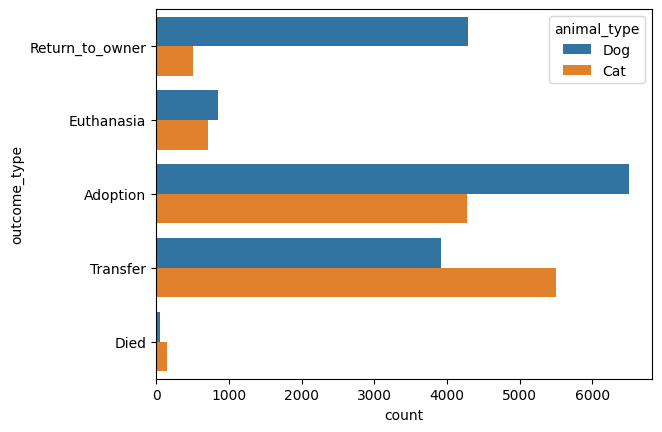

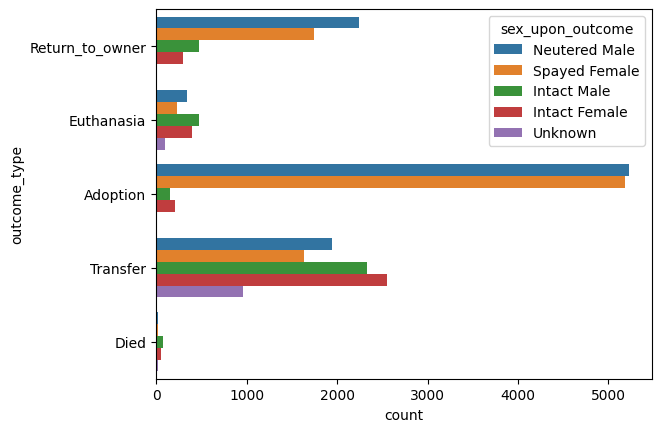

In [5]:
for col in ['animal_type', 'sex_upon_outcome']:
    fig, ax = plt.subplots()
    sns.countplot(y='outcome_type', hue=col, data=train, ax=ax)

Animals with age know were more often returned to their owners:

In [6]:
(
    train
    .assign(has_known_age=lambda x: x['age_upon_outcome'].str.contains('year'))
    .pivot_table('animal_id', 'has_known_age', 'outcome_type', aggfunc='nunique')
)

outcome_type,Adoption,Died,Euthanasia,Return_to_owner,Transfer
has_known_age,,,,,
False,5740,138,371,513,5124
True,5029,59,1184,4273,4298


## Training a model

Let's see if we can train a model!

### Split train and test set

In [7]:
X = train.drop('outcome_type', axis=1)
y = train['outcome_type']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

### Baseline

Naively select some columns of `X` and dummify them:

In [9]:
simple_cols = ['animal_type', 'sex_upon_outcome']

X_train_dummies = pd.get_dummies(X_train.loc[:, simple_cols])

We'll use `cross_val_score` to quickly get a feeling for the cross validation score.

Get a baseline for all classes by randomly prediction with occurrence of the classes:

In [10]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

cross_val_score(DummyClassifier(), X_train_dummies,
                y_train, scoring='neg_log_loss', cv=5)

array([-1.24374374, -1.24354991, -1.24357794, -1.24424475, -1.2438132 ])

### Model selection and hyperparameter tuning

What would logistic regression do?

In [11]:
from sklearn.linear_model import LogisticRegression

cross_val_score(LogisticRegression(C=0.1), X_train_dummies,
                y_train, scoring='neg_log_loss', cv=5)

array([-0.99804784, -0.98940733, -0.98786307, -1.00550078, -1.01009024])

Better than the baseline!

Let's find an optimal logistic regression model given these features.
We'll try to optimize regularization parameter `C`.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [1E-3, 1E-2, 1E-1]}
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring='neg_log_loss')

grid_search.fit(X_train_dummies, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1]}, scoring='neg_log_loss')

Our best score is:

In [13]:
grid_search.best_score_

-0.9981818495741063

The best parameter was:

In [14]:
grid_search.best_params_

{'C': 0.1}

Our best model is:

In [15]:
best_model = grid_search.best_estimator_

Save it:

In [16]:
joblib.dump(best_model, '../output/outcome_model.pickle')

['../output/outcome_model.pickle']

### <mark>Exercise: Train a model</mark>

Take the relevant parts from 'Loading data' and 'Training a model' and use it to fill the function `train()` in `src/animal_shelter/cli.py`.

Afterwards run the code from the command line using the`train.csv` data in the `data` folder.

```python
poetry run animal_shelter train data/train.csv output/model.pickle  
```


## Making predictions

Load the previous model and data that we want predictions for:

In [17]:
outcome_model = joblib.load('../output/outcome_model.pickle')
test = data.load_data('../data/test.csv')
X_test = test  # no y in there

In [18]:
X_test.head()

,id,name,date_time,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


Get predictions

In [19]:
X_pred_dummies = pd.get_dummies(X_test.loc[:, simple_cols])
y_pred = outcome_model.predict_proba(X_pred_dummies)

In [20]:
y_pred

array([[0.05763344, 0.00878518, 0.12691036, 0.17410602, 0.63256499],
       [0.53384923, 0.00177771, 0.02776147, 0.27605258, 0.16055901],
       [0.63709905, 0.00526175, 0.03569593, 0.06304134, 0.25890193],
       ...,
       [0.06276641, 0.01908142, 0.10144326, 0.02971522, 0.78699368],
       [0.48365108, 0.00200285, 0.03692075, 0.30537832, 0.17204701],
       [0.04413983, 0.01157935, 0.14342056, 0.24050653, 0.56035373]])

Get the classes and create a DataFrame with the probabilities:

In [21]:
classes = outcome_model.classes_.tolist()
classes

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

In [22]:
proba_df = pd.DataFrame(y_pred, columns=classes)
proba_df.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,0.057633,0.008785,0.126910,0.174106,0.632565
1,0.533849,0.001778,0.027761,0.276053,0.160559
2,0.637099,0.005262,0.035696,0.063041,0.258902
3,0.044140,0.011579,0.143421,0.240507,0.560354
4,0.483651,0.002003,0.036921,0.305378,0.172047


Add the ID, reorder columns and save as CSV.:

In [23]:
proba_df['id'] = test['id']
reordered = proba_df[['id'] + classes]
reordered.to_csv('../output/predictions.csv', index=False)

### <mark>Exercise: Make predictions using the CLI</mark>

Take the relevant parts from 'Making predictions' and create a new command `predict` with:
* input: `--input_path`: path with the CSV to create preditions for.
* input: `--model_path`: path to the model saved with `train`.
* output: `--output_path`: path to output CSV with predictions.

Afterwards run the code from the command line using the`test.csv` data in the `data` folder.

```python
poetry run animal_shelter test data/test.csv output/model.pickle output/predictions.csv      
```